In [1]:
import networkx as nx
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from dynamics import ModelDynamics

# Uncontrolled epidemic experiment with a single-node system

In [4]:
def direct_plot(total_history):
    plt.rcParams['figure.figsize'] = [12, 12]
    
    fig, ax = plt.subplots(2,2)
    
    t_suceptible = np.array([t['suceptible'] for t in total_history])
    t_exposed = np.array([t['exposed'] for t in total_history])
    t_infected = np.array([t['infected'] for t in total_history])
    t_recovered = np.array([t['recovered'] for t in total_history])
    t_dead = np.array([t['dead'] for t in total_history])
    # plot 1 "fake SI"
    ax[0,0].plot(np.array(t_suceptible) + np.array(t_recovered) + np.array(t_exposed))
    ax[0,0].plot(t_infected)
    ax[0,0].plot(t_dead)
    ax[0,0].legend(['non infected', 'infected', 'dead'])
    ax[0,0].axhline(0,color='black')
    ax[0,0].axhline(total_history[0]['initial population'],color='black')
    ax[0,0].set_title('Measurable')
    
    # plot 2 "SIR"
    ax[0,1].plot(np.array(t_suceptible))
    ax[0,1].plot(t_exposed)
    ax[0,1].plot(t_infected)
    ax[0,1].plot(np.array(t_recovered))
    ax[0,1].plot(t_dead)
    ax[0,1].legend(['suceptible', 'exposed', 'infected', 'recovered', 'dead'])
    ax[0,1].axhline(0,color='black')
    ax[0,1].axhline(total_history[0]['initial population'],color='black')
    ax[0,1].set_title('SIR')
    
    # plot 3 "Phase plane 1"
    ax[1,0].plot(np.array(t_suceptible),t_infected)
    ax[1,0].set_xlabel('S')
    ax[1,0].set_ylabel('I')
    ax[1,0].set_title('SI plot')
    
    # plot 3 "Death rate 1"
    ax[1,1].plot(t_infected[1:],t_dead[1:]-t_dead[0:-1])
    ax[1,1].set_xlabel('I')
    ax[1,1].set_ylabel('D')
    ax[1,1].set_title('Death rate plot')
    
    fig.tight_layout()
    
    plt.show()
    

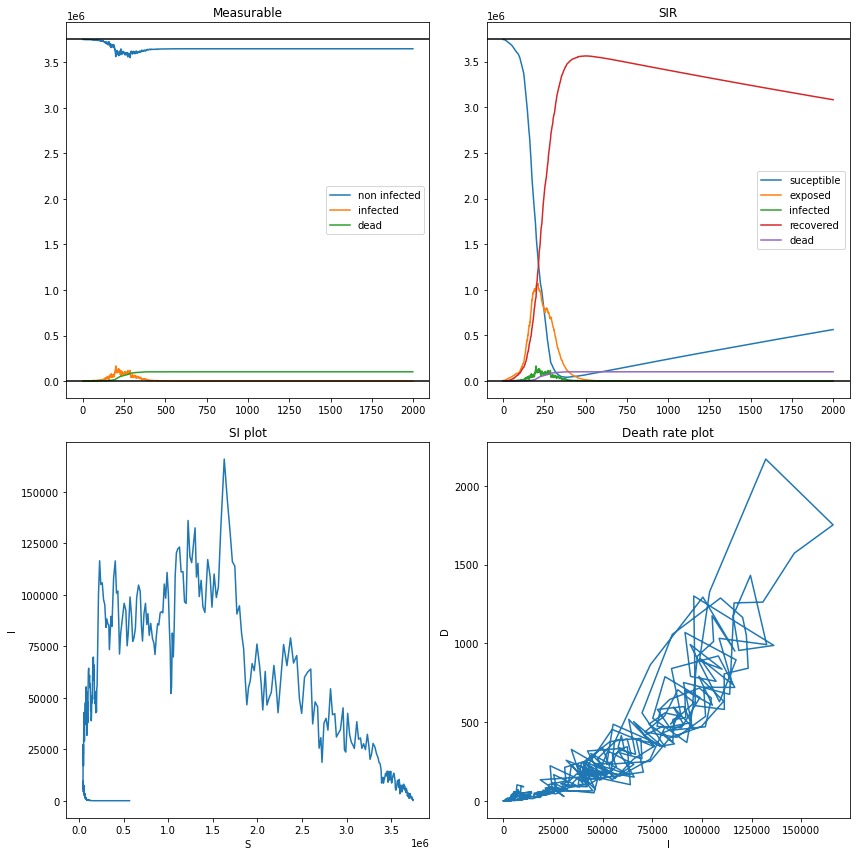

In [5]:

dyn = ModelDynamics('./config/switzerland.yaml')
dyn.start_epidemic(prop=0.05)
total_history = []
city_history = []
for i in range(2000):
    dyn.step_dyn()
    total, cities = dyn.epidemic_parameters()
    total_history.append(total)
    city_history.append(cities)
    
direct_plot(total_history)

# Naive policy experiment with a multiple-node model

In [9]:
def plot_per_city(city_history):
    plt.rcParams['figure.figsize'] = [12, 12]

    fig, ax = plt.subplots(len(city_history[0].keys()),1)
    i = 0
    for c in city_history[0].keys():
        c_suceptible = [h[c]['suceptible'] for h in city_history]
        c_infected = [h[c]['infected'] for h in city_history]
        c_recovered = [h[c]['recovered'] for h in city_history]
        c_dead = [h[c]['dead'] for h in city_history]
        ax[i].plot(c_infected)
        ax[i].plot(c_dead)
        ax[i].legend(['infected', 'dead'], loc='upper right')
        ax[i].set_title(c)
        i+= 1
    fig.tight_layout()
def plot(total_history, confinement_history=None):
    plt.rcParams['figure.figsize'] = [12, 12]
    
    fig, ax = plt.subplots(2,2)
    
    t_suceptible = np.array([t['suceptible'] for t in total_history])
    t_infected = np.array([t['infected'] for t in total_history])
    t_recovered = np.array([t['recovered'] for t in total_history])
    t_exposed = np.array([t['exposed'] for t in total_history])
    t_dead = np.array([t['dead'] for t in total_history])
    # plot 1 "fake SI"
    # ax[0,0].plot(np.array(t_suceptible) + np.array(t_recovered))
    ax[0,0].plot(t_infected)
    ax[0,0].plot(t_dead)
    if confinement_history is not None:
        ax[0,0].plot(np.array(confinement_history)*20000)
        ax[0,0].legend(['infected', 'dead', 'confinement'])
    else:
        ax[0,0].legend(['infected', 'dead'])
    ax[0,0].axhline(0,color='black')
    # ax[0,0].axhline(total_history[0]['initial population'],color='black')
    ax[0,0].set_title('Measurable')
    
    # plot 2 "SIR"
    # ax[0,1].plot(np.array(t_suceptible))
    ax[0,1].plot(t_infected)
    ax[0,1].plot(np.array(t_recovered))
    ax[0,1].plot(np.array(t_exposed))
    ax[0,1].plot(t_dead)
    ax[0,1].legend(['infected', 'recovered', 'exposed', 'dead'])
    ax[0,1].axhline(0,color='black')
    # ax[0,1].axhline(total_history[0]['initial population'],color='black')
    ax[0,1].set_title('SIR')
    
    # plot 3 "Phase plane 1"
    ax[1,0].plot(np.array(t_suceptible),t_infected)
    ax[1,0].set_xlabel('S')
    ax[1,0].set_ylabel('I')
    ax[1,0].set_title('SI plot')
    
    # plot 3 "Death rate 1"
    ax[1,1].plot(t_infected[1:],t_dead[1:]-t_dead[0:-1])
    ax[1,1].set_xlabel('I')
    ax[1,1].set_ylabel('D')
    ax[1,1].set_title('Death rate plot')
    
    fig.tight_layout()
    
    plt.show()

In [10]:
def naive_run(isolate=False,hospital=False, vaccinate=False, auto_plot=True,time=100,thresh=30000):

    total_history = []
    city_history = []
    confinement_history = []
    
    dyn = ModelDynamics('./config/switzerland.yaml')
    act = {}
    act['confinement'] = {c:False for c in dyn.cities}
    act['isolation'] = {c:isolate for c in dyn.cities}
    act['hospital'] = {c:hospital for c in dyn.cities}
    act['vaccinate'] = vaccinate
        
    dyn.start_epidemic(prop=0.05)
    confinement_time = 10
    timer = -1

    for i in range(time):
        total, cities = dyn.epidemic_parameters()
        if total['infected']>thresh or timer >= 0:
                if timer == -1:
                    timer = confinement_time
                timer -= 1
                act['confinement'] = {c:True for c in dyn.cities}
                confinement_history.append(1.0)    
                obs = dyn.step(act)
        else:
            obs = dyn.step(act)
            act['confinement'] = {c:False for c in dyn.cities}
            confinement_history.append(0.0)
            
        total, cities = dyn.epidemic_parameters()
        total_history.append(total)
        city_history.append(cities)
        
    if auto_plot:
        plot(total_history)
        plot_per_city(city_history)
        
    return total_history, confinement_history

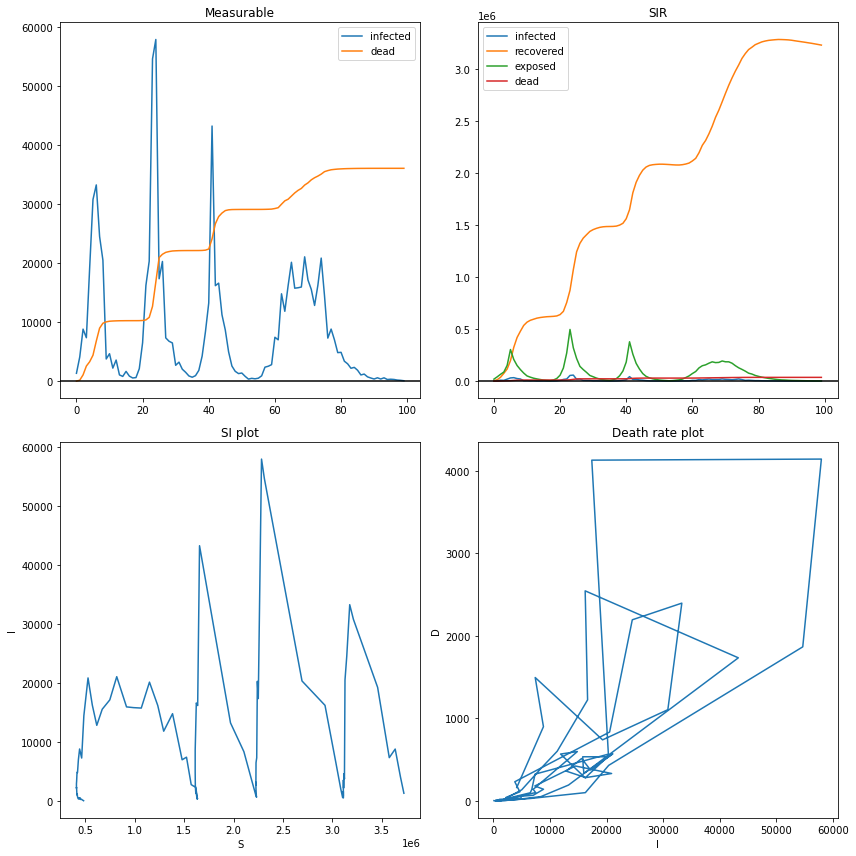

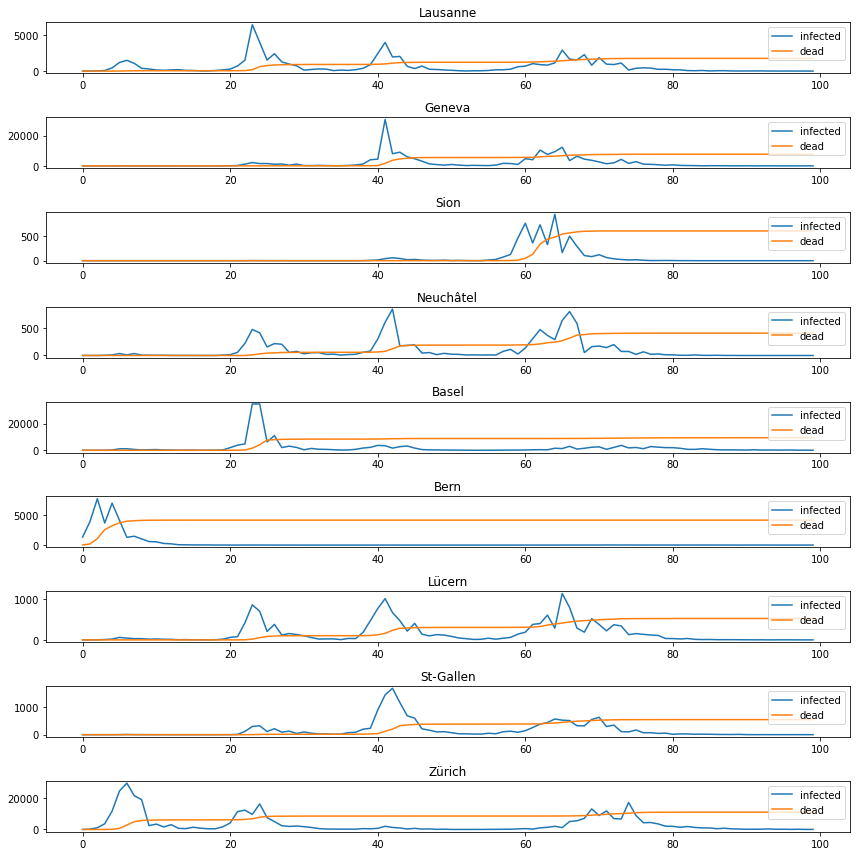

In [11]:

dyn = ModelDynamics('./config/switzerland.yaml')

_ = naive_run(time=100)

In [54]:
base, base_confinement = naive_run(isolate=False,hospital=False, vaccinate=False, auto_plot=False,time=200)
isolate, isolate_confinement = naive_run(isolate=True,hospital=False, vaccinate=False, auto_plot=False,time=200)
hospital, hospital_confinement = naive_run(isolate=False,hospital=True, vaccinate=False, auto_plot=False,time=200)
vaccinate, vaccinate_confinement = naive_run(isolate=False,hospital=False, vaccinate=True, auto_plot=False,time=200)

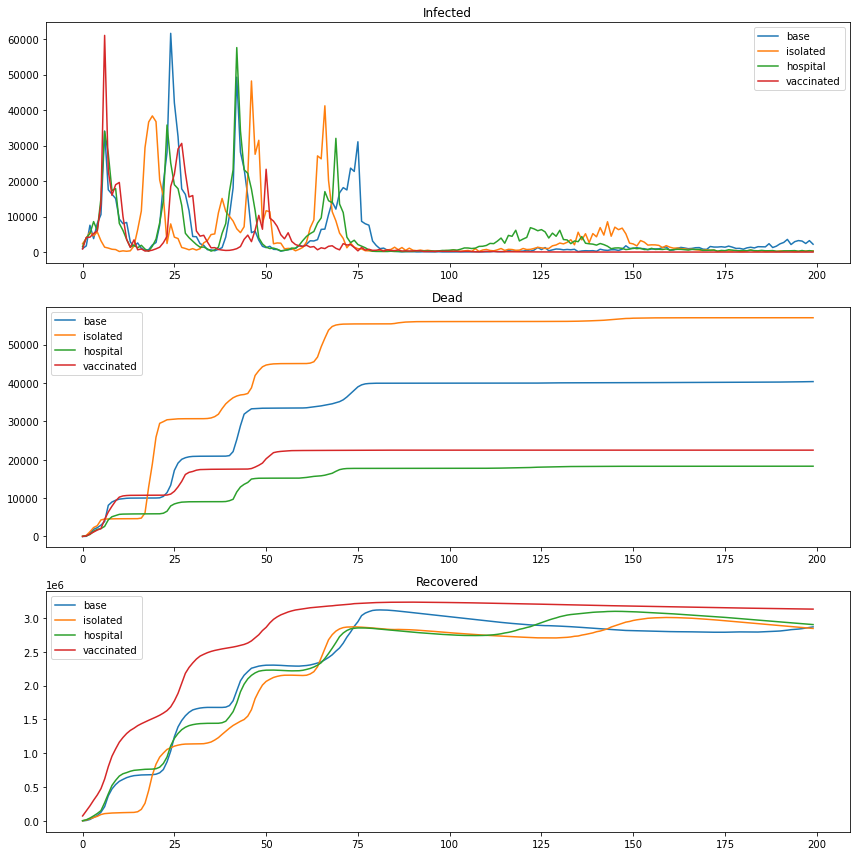

In [69]:

plt.rcParams['figure.figsize'] = [12, 12]

fig, ax = plt.subplots(3,1)
infected_base       = np.array([t['infected'] for t in base])
infected_isolate    = np.array([t['infected'] for t in isolate])
infected_hospital   = np.array([t['infected'] for t in hospital])
infected_vaccinate  = np.array([t['infected'] for t in vaccinate])
dead_base           = np.array([t['dead'] for t in base])
dead_isolate        = np.array([t['dead'] for t in isolate])
dead_hospital       = np.array([t['dead'] for t in hospital])
dead_vaccinate      = np.array([t['dead'] for t in vaccinate])
infected_vaccinate  = np.array([t['infected'] for t in vaccinate])
rec_base            = np.array([t['recovered'] for t in base])
rec_isolate         = np.array([t['recovered'] for t in isolate])
rec_hospital        = np.array([t['recovered'] for t in hospital])
rec_vaccinate       = np.array([t['recovered'] for t in vaccinate])

# plot 1 "fake SI"
ax[0].plot(infected_base)
ax[0].plot(infected_isolate)
ax[0].plot(infected_hospital)
ax[0].plot(infected_vaccinate)
ax[0].set_title('Infected')
ax[0].legend(['base', 'isolated', 'hospital','vaccinated'])

ax[1].plot(dead_base)
ax[1].plot(dead_isolate)
ax[1].plot(dead_hospital)
ax[1].plot(dead_vaccinate)
ax[1].set_title('Dead')
ax[1].legend(['base', 'isolated', 'hospital','vaccinated'])

ax[2].plot(rec_base)
ax[2].plot(rec_isolate)
ax[2].plot(rec_hospital)
ax[2].plot(rec_vaccinate)
ax[2].set_title('Recovered')
ax[2].legend(['base', 'isolated', 'hospital','vaccinated'])

fig.tight_layout()

In [63]:
t0, c0 = naive_run(thresh=5000,auto_plot=False,time=100)
t1, c1 = naive_run(thresh=10000,auto_plot=False,time=100)
t2, c2 = naive_run(thresh=20000,auto_plot=False,time=100)
t3, c3 = naive_run(thresh=30000,auto_plot=False,time=100)
t4, c4 = naive_run(thresh=40000,auto_plot=False,time=100)
t5, c5 = naive_run(thresh=50000,auto_plot=False,time=100)

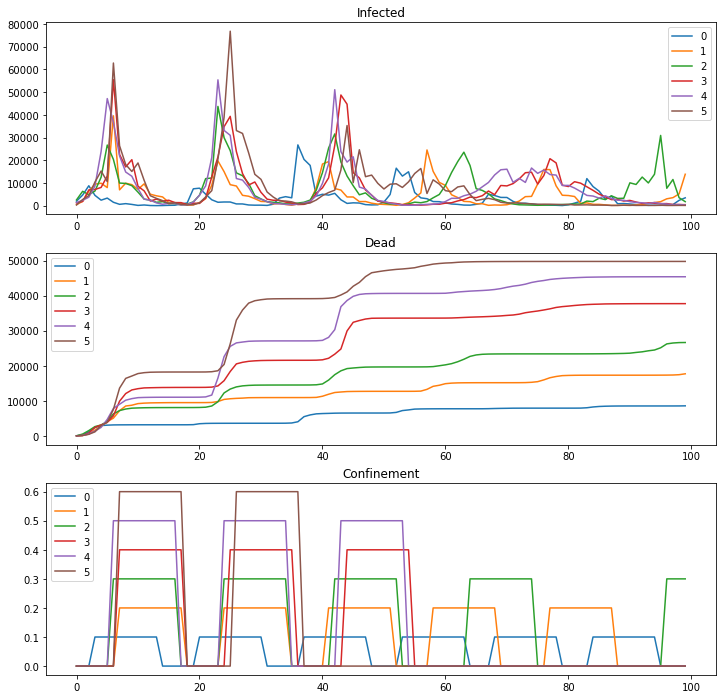

In [66]:
infected_0          = np.array([t['infected'] for t in t0])
infected_1          = np.array([t['infected'] for t in t1])
infected_2          = np.array([t['infected'] for t in t2])
infected_3          = np.array([t['infected'] for t in t3])
infected_4          = np.array([t['infected'] for t in t4])
infected_5          = np.array([t['infected'] for t in t5])
dead_0              = np.array([t['dead'] for t in t0])
dead_1              = np.array([t['dead'] for t in t1])
dead_2              = np.array([t['dead'] for t in t2])
dead_3              = np.array([t['dead'] for t in t3])
dead_4              = np.array([t['dead'] for t in t4])
dead_5              = np.array([t['dead'] for t in t5])



plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots(3,1)
# plot 1 "fake SI"
ax[0].plot(infected_0)
ax[0].plot(infected_1)
ax[0].plot(infected_2)
ax[0].plot(infected_3)
ax[0].plot(infected_4)
ax[0].plot(infected_5)
ax[0].set_title('Infected')
ax[0].legend(['0','1', '2', '3','4','5'])

ax[1].plot(dead_0)
ax[1].plot(dead_1)
ax[1].plot(dead_2)
ax[1].plot(dead_3)
ax[1].plot(dead_4)
ax[1].plot(dead_5)
ax[1].set_title('Dead')
ax[1].legend(['0','1', '2', '3','4','5'])

ax[2].plot(np.array(c0)*0.1)
ax[2].plot(np.array(c1)*0.2)
ax[2].plot(np.array(c2)*0.3)
ax[2].plot(np.array(c3)*0.4)
ax[2].plot(np.array(c4)*0.5)
ax[2].plot(np.array(c5)*0.6)
ax[2].set_title('Confinement')
ax[2].legend(['0','1', '2', '3','4','5'])
